### 01. Pytorch Workflow
Resource Notebook: https://www.learnpytorch.io/01_pytorch_workflow/

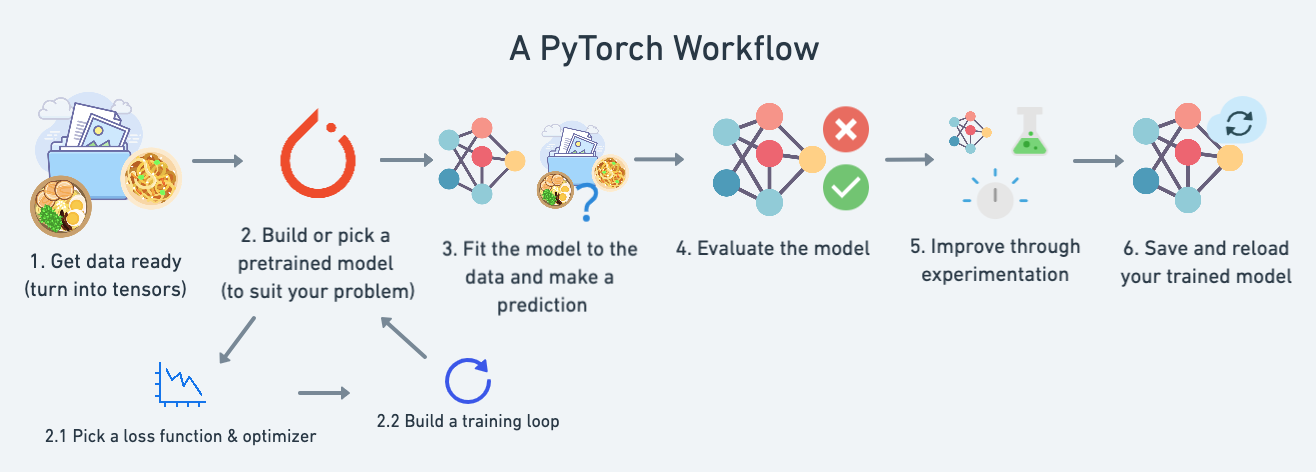

In [112]:
what_were_covering = {1: "data (prep and load)",
                      2: "build model",
                      3: "fit model to data (training)",
                      4: "save and load the model",
                      5: "put it all together"}

what_were_covering

{1: 'data (prep and load)',
 2: 'build model',
 3: 'fit model to data (training)',
 4: 'save and load the model',
 5: 'put it all together'}

In [113]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu118'

from torch.serialization import MAP_LOCATION
## Preparing Data

Data can be almost anything in ML:
- Excel spreadsheets
- Images
- Videos
- DNA

ML is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

In [114]:
## LINEAR REGRESSION:

# Create known parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [115]:
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [116]:
len(X), len(y)

(50, 50)

### Splitting the data into training and test set

Also look at scikit-learn's train_test_split method:

> ```from sklearn.model_selection import train_test_split```



In [117]:
# Create a train / test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### Visualize data using **Matplotlib**

In [118]:
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
    """
    Plots train, test data and compares predictions
    """

    plt.figure(figsize=(10,7))

    # Train data Scatterplot in blue
    plt.scatter(train_data, train_labels, c='b', s=4, label='Train data')

    # Test data Scatterplot in green
    plt.scatter(test_data, test_labels, c='g', s=4, label='Test data')

    # Are there predictions?
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

    # Show the legend
    plt.legend(prop={"size": 14})

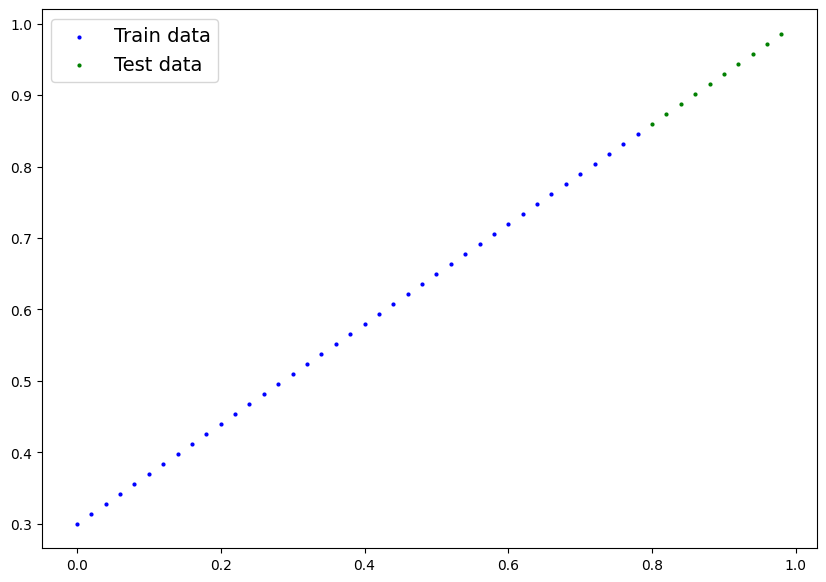

In [119]:
plot_predictions(X_train, y_train, X_test, y_test)

### Build a Linear Regression Model

- Get weight and bias from random initial values to ideal values, using:
  * Gradient descent
  * Backpropagation

In [120]:
# Create Linear Regression model class
class LinearRegressionModel(nn.Module):   # Almost everything in Pytorch inherits from nn.Module (Base class for all Neural Network modules)

    def __init__(self):
        super().__init__()

        # A parameter is a value that the model sets itself
        # A hyperparameter is a value that we set (eg. learning rate for Gradient Descent (explained below))
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,   # for gradient descent
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Forward method to define computation in the model
        return self.weights * x + self.bias   # linear regression formula




### PyTorch model building essentials
- `torch.nn`: Contains all of the building blocks for computational graphs (NN can be considered a computational graph)
- `torch.nn`.Parameter: What parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
- `torch.nn`.Module: Base class for all NN modules. If you subclass it, you should override `forward()`
- `torch.optim`: This is where optimizers in PyTorch live, they will help with Gradient Descent
- `def forward()`: All `nn.Module` subclasses requires you to override `forward()`, this method defines what happens in the forward computation

Also look into:
  * `torch.utils.data.Dataset`
  * `torch.utils.data.DataLoader`


PyTorch Cheat Sheet:

https://pytorch.org/tutorials/beginner/ptcheat.html

### Checking the contents of our PyTorch model

Checking model parameters using .parameters()

In [121]:
# Create a random seed (for reproducible results)
torch.manual_seed(42)

# Create an instance of the model (this is sublass of nn.Module)
model_0 = LinearRegressionModel()

# Check out parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [122]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [123]:
weight, bias  # Need to get self.weights and self.bias to these

(0.7, 0.3)

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` from `X_test`

In [124]:
# Make predictions with model

with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

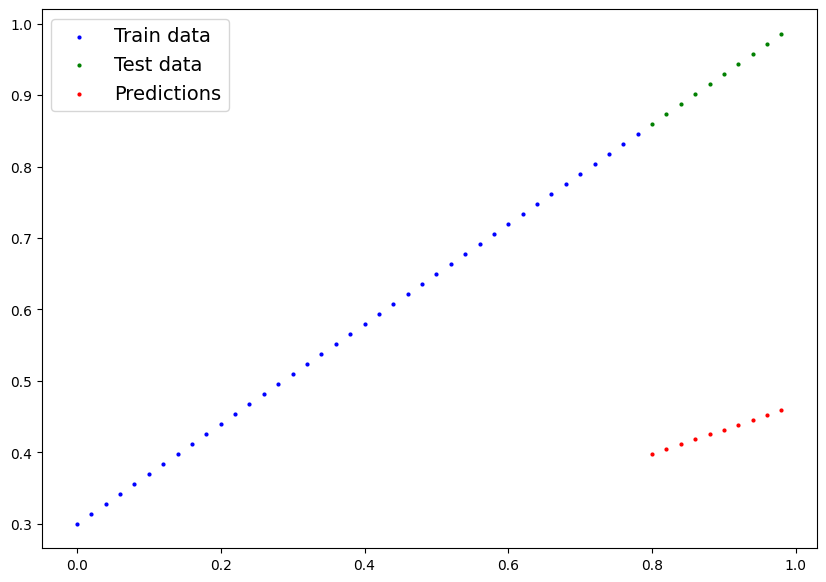

In [125]:
plot_predictions(X_train, y_train, X_test, y_test, predictions=y_preds)

### Train Model

- **Loss function (Cost function)**: Measure how good (or poor) your model predictions are, lower is better.
- **Optimizer**: Takes into account the loss of a model and adjusts the model's parameters (eg. weights and bias) to improve the loss function

For PyTorch, we need:
- A training loop
- A testing loop

In [126]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [127]:
# Setup a loss function
loss_fn = nn.L1Loss()   # L1Loss = Mean Absolute Error

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),        # SGD = Stochastic Gradient Descent
                            lr=0.01)                            # lr = Learning Rate, dictates the change in parameter at each step of GD, important GD hyperparameter

### Building a training and testing loop in PyTorch

0. Loop through the data and do...
1. Forward pass (moving through our model's `forward()` function) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss Backward - Move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)


In [128]:
# An epoch is one loop through the data (this is a hyperparameter, since we set it ourselves)
epochs = 200

epoch_count = []
train_loss_values = []
test_loss_values = []

# 0. Loop through the data
for epoch in range(epochs):
    model_0.train()

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    # print(f'Loss: {loss}')

    # 3. Optimizer zero grad
    # Zero the optimizer gradient (see comment at 5.)
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss wrt model parameters
    # Compute the gradient of every param with requires_grad=True
    loss.backward()

    # 5. Step / Progress through the optimizer (perform gradient descent)
    # By default how the optimizer changes will accumulate through the loop
    # So, we have to zero them above in Step 3 for the next iteration of the loop
    optimizer.step()

    # Testing Mode
    model_0.eval()
    with torch.inference_mode():    # turns of gradient tracking and couple more things to make our code faster
        # 1. Do forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening:
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Train Loss: {loss} | Test Loss: {test_loss}")

# print(f'Loss: {loss}')
print(model_0.state_dict())

Epoch: 0 | Train Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
Epoch: 10 | Train Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
Epoch: 20 | Train Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
Epoch: 30 | Train Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
Epoch: 40 | Train Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
Epoch: 50 | Train Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
Epoch: 60 | Train Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
Epoch: 70 | Train Loss: 0.03476089984178543 | Test Loss: 0.0805937647819519
Epoch: 80 | Train Loss: 0.03132382780313492 | Test Loss: 0.07232122868299484
Epoch: 90 | Train Loss: 0.02788739837706089 | Test Loss: 0.06473556160926819
Epoch: 100 | Train Loss: 0.024458957836031914 | Test Loss: 0.05646304413676262
Epoch: 110 | Train Loss: 0.021020207554101944 | Test Loss: 0.04819049686193466
Epoch: 120 | Train Loss: 0.01758546568453312 | Test Loss: 0.040604822337627

In [129]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [130]:
# Actual weight and bias
weight, bias

(0.7, 0.3)

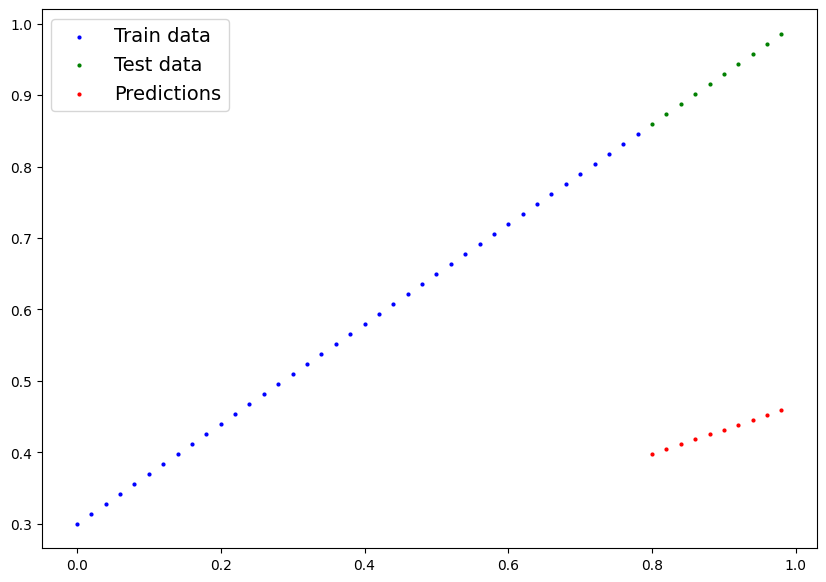

In [131]:
# Old plot
plot_predictions(X_train, y_train, X_test, y_test, predictions=y_preds)

In [132]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

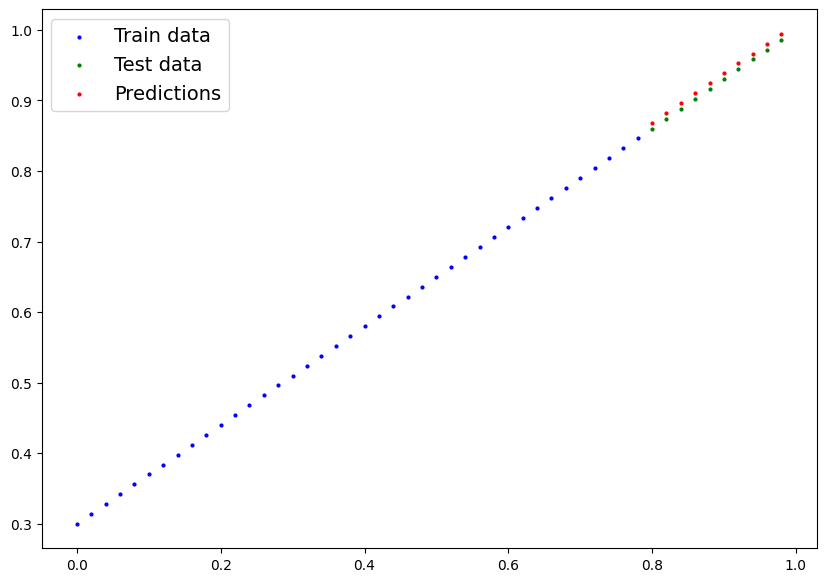

In [133]:
# New plot trained on ML loop
plot_predictions(X_train, y_train, X_test, y_test, predictions=y_preds_new)

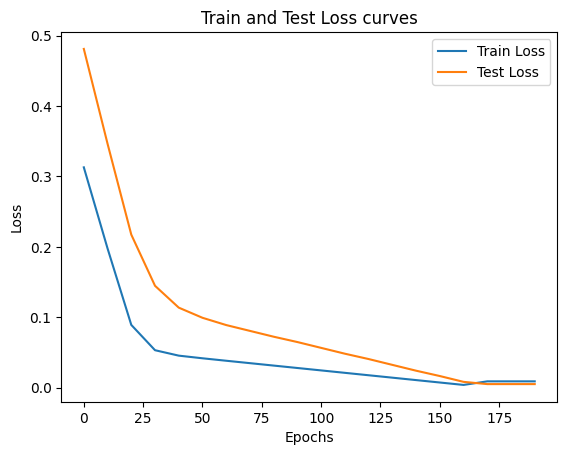

In [135]:
# Plot the loss curves
plt.plot(epoch_count, torch.tensor(train_loss_values).cpu().numpy(), label='Train Loss')
plt.plot(epoch_count, test_loss_values, label='Test Loss')
plt.title("Train and Test Loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

### Saving a model in PyTorch

1. `torch.save()`: Allows you to save a PyTorch object in Python's pickle format
2. `torch.load()`: Allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()`: Allows you to load a model's saved state dictionary

See: https://pytorch.org/tutorials/beginner/saving_loading_models.html


In [136]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [137]:
# Instantiate a fresh instance of LinearRegressionModel
loaded_model_0 = LinearRegressionModel()

# Load model state dict
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [138]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [141]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [142]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [143]:
loaded_model_preds == y_preds_new

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### Putting it all together

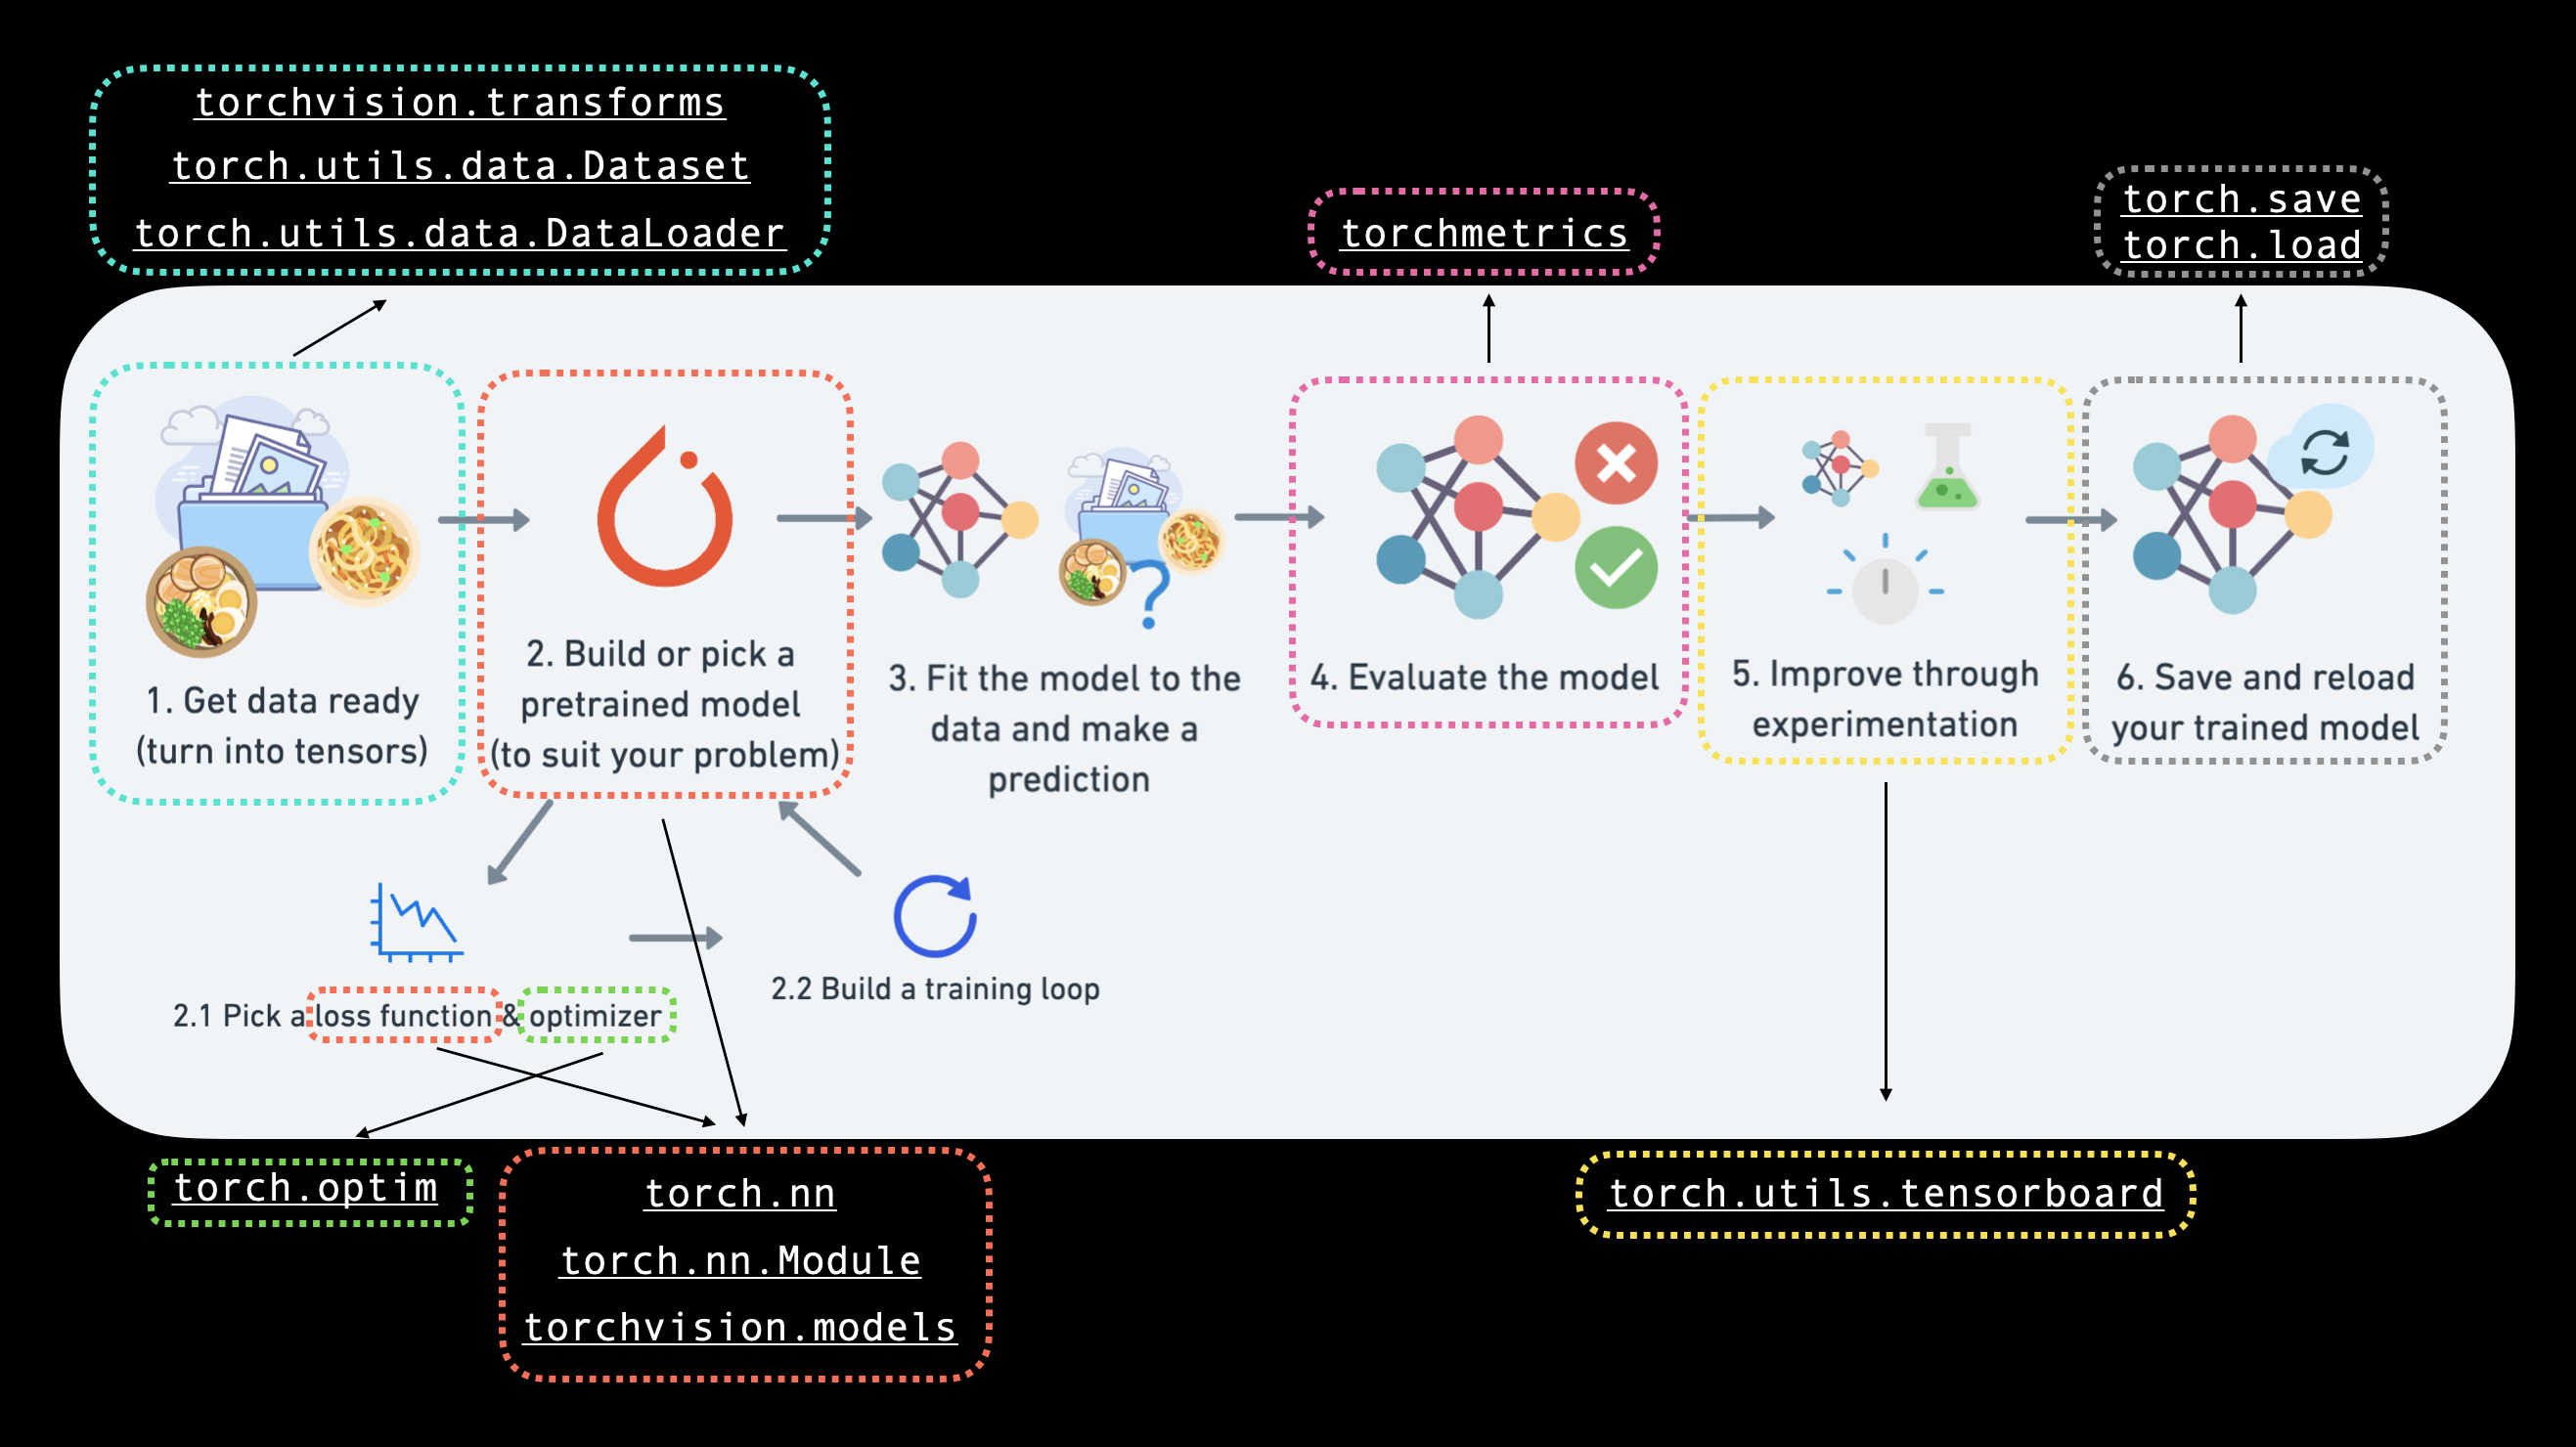

Create device agnostic code.

So that our code will used GPU if available, else it will use CPU

In [145]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}')

Using device: cpu
